In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (mean_squared_error, r2_score, classification_report, 
                           confusion_matrix, roc_auc_score, roc_curve)
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [22]:
# Load the dataset
df = pd.read_csv("10k_diabetes (1).csv")

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()

# Display first few rows
print("\nFirst few rows of the dataset:")
df.head()

# Check missing values
print("\nMissing values in each column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Dataset Shape: (10000, 51)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      10000 non-null  object
 1   gender                    10000 non-null  object
 2   age                       10000 non-null  object
 3   weight                    10000 non-null  object
 4   admission_type_id         9279 non-null   object
 5   discharge_disposition_id  9531 non-null   object
 6   admission_source_id       9064 non-null   object
 7   time_in_hospital          10000 non-null  int64 
 8   payer_code                10000 non-null  object
 9   medical_specialty         10000 non-null  object
 10  num_lab_procedures        10000 non-null  int64 
 11  num_procedures            10000 non-null  int64 
 12  num_medications           10000 non-null  int64 
 13  number_outpatient         10000 non

In [23]:
# Replace '?' with 'Unknown' for weight
df['weight'] = df['weight'].replace('?', 'Unknown')

# Replace '?' with 'Unknown' for weight
df['medical_specialty'] = df['medical_specialty'].replace('?', 'Unknown')

df['payer_code'] = df['payer_code'].replace("?", 'Unknown')


# Fill missing admission types with mode
df['admission_type_id'] = df['admission_type_id'].fillna(df['admission_type_id'].mode()[0])
df['admission_source_id'] = df['admission_source_id'].fillna(df['admission_source_id'].mode()[0])

# Convert age ranges to numeric midpoints
def age_to_midpoint(age_range):
    if pd.isna(age_range) or age_range == '?':
        return None
    nums = [int(x) for x in age_range.strip('[]()').split('-')]
    return sum(nums) / 2

df['age_numeric'] = df['age'].apply(age_to_midpoint)

# Verify changes
print("Unique values in weight column:", df['weight'].unique())
print("\nUnique values in age_numeric:", df['age_numeric'].unique())

Unique values in weight column: ['Unknown' '[50-75)' '[75-100)' '[100-125)' '[150-175)' '[0-25)'
 '[125-150)' '[25-50)']

Unique values in age_numeric: [55. 25. 85. 75. 65. 35. 45. 15. 95.  5.]


In [25]:
df['readmitted'].unique()

array([False,  True])

Value counts in readmitted_30:
readmitted_30
0    6035
1    3965
Name: count, dtype: int64


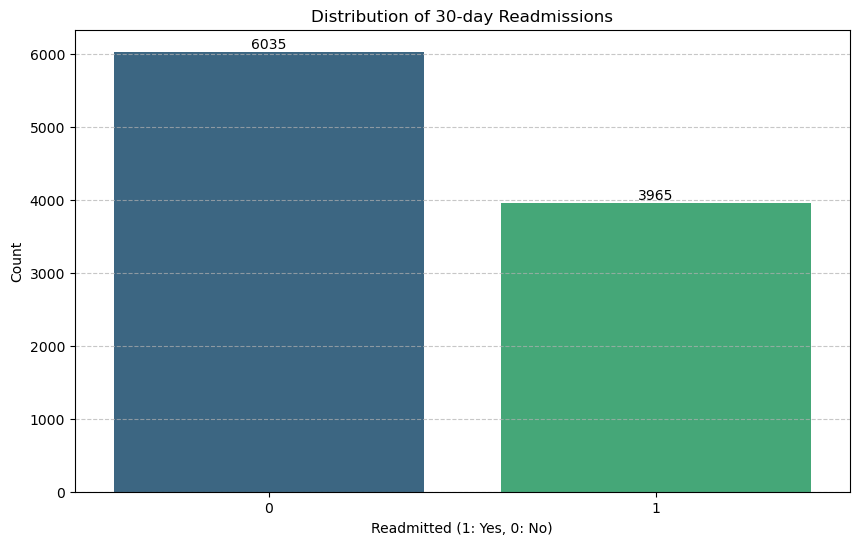

Readmission Rate: 39.65%

Detailed Statistics:
--------------------------------------------------
Total patients: 10000
Number of readmissions: 3965
Number of non-readmissions: 6035


In [26]:
# Create binary readmission target - directly convert boolean to int
df['readmitted_30'] = df['readmitted'].astype(int)

# Verify the values
print("Value counts in readmitted_30:")
print(df['readmitted_30'].value_counts())

# Plot readmission distribution with adjusted figure size and style
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='readmitted_30', palette='viridis')
plt.title('Distribution of 30-day Readmissions')
plt.xlabel('Readmitted (1: Yes, 0: No)')
plt.ylabel('Count')

# Add value labels on top of each bar
for i in plt.gca().containers:
    plt.gca().bar_label(i)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Print readmission rate
readmission_rate = df['readmitted_30'].mean() * 100
print(f"Readmission Rate: {readmission_rate:.2f}%")

# Additional statistics
print("\nDetailed Statistics:")
print("-" * 50)
print("Total patients:", len(df))
print("Number of readmissions:", df['readmitted_30'].sum())
print("Number of non-readmissions:", len(df) - df['readmitted_30'].sum())


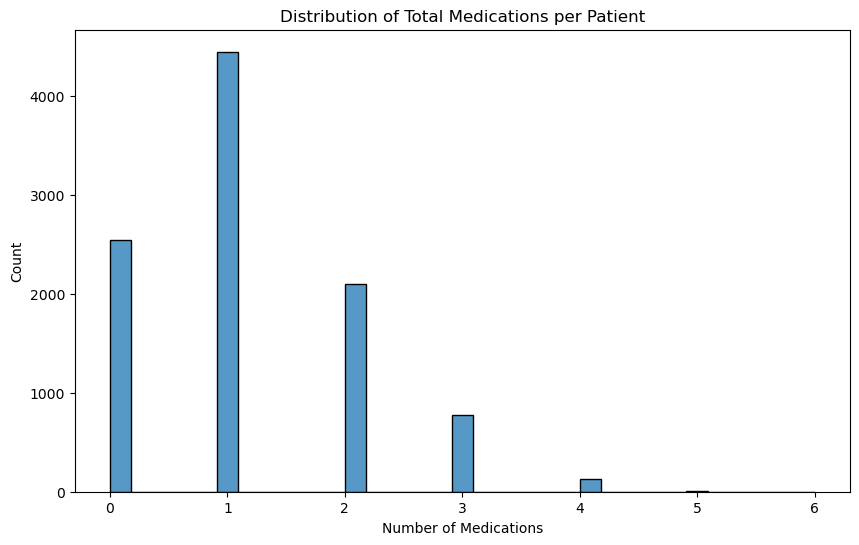

In [27]:
# List of medication columns
med_columns = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
              'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
              'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
              'miglitol', 'troglitazone', 'tolazamide', 'examide',
              'citoglipton', 'insulin']

# Create medication features
df['medication_changes'] = df['change'].map({'No': 0, 'Ch': 1})
df['total_medications'] = df[med_columns].apply(lambda x: sum(x != 'No'), axis=1)
df['insulin_status'] = df['insulin'].map({
    'No': 0,
    'Steady': 1,
    'Up': 2,
    'Down': 3
})

# Visualize medication distributions
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='total_medications')
plt.title('Distribution of Total Medications per Patient')
plt.xlabel('Number of Medications')
plt.ylabel('Count')
plt.show()

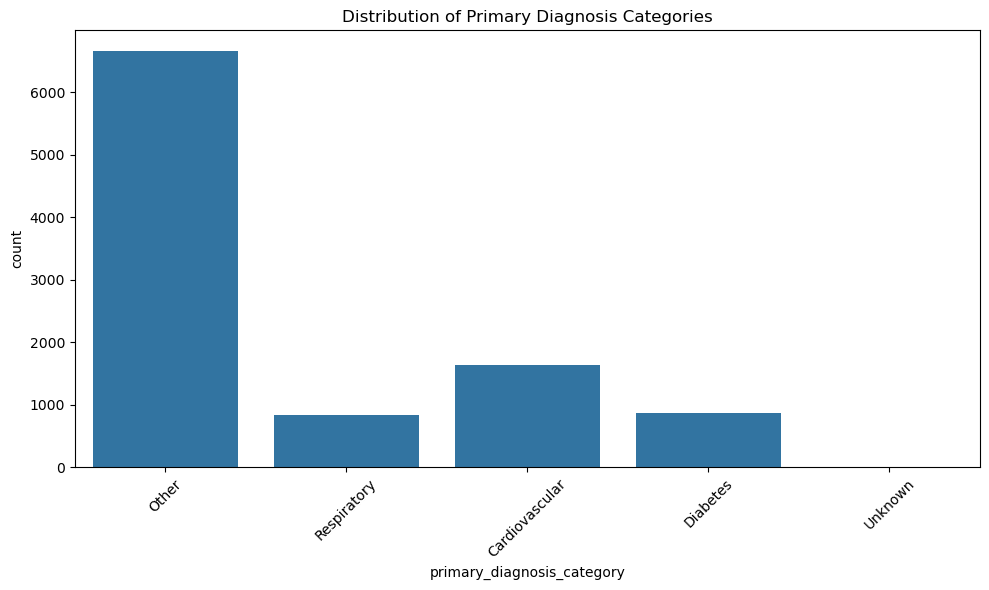

In [28]:
def categorize_diagnosis(diag_desc):
    if pd.isna(diag_desc):
        return 'Unknown'
    diag_lower = str(diag_desc).lower()
    if 'diabetes' in diag_lower:
        return 'Diabetes'
    elif any(x in diag_lower for x in ['heart', 'cardiac', 'coronary']):
        return 'Cardiovascular'
    elif any(x in diag_lower for x in ['respiratory', 'pneumonia', 'copd']):
        return 'Respiratory'
    else:
        return 'Other'

# Categorize primary diagnosis
df['primary_diagnosis_category'] = df['diag_1_desc'].apply(categorize_diagnosis)

# Create dummy variables for diagnosis categories
diagnosis_dummies = pd.get_dummies(df['primary_diagnosis_category'], 
                                 prefix='diag_cat')
df = pd.concat([df, diagnosis_dummies], axis=1)

# Visualize diagnosis distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='primary_diagnosis_category')
plt.xticks(rotation=45)
plt.title('Distribution of Primary Diagnosis Categories')
plt.tight_layout()
plt.show()

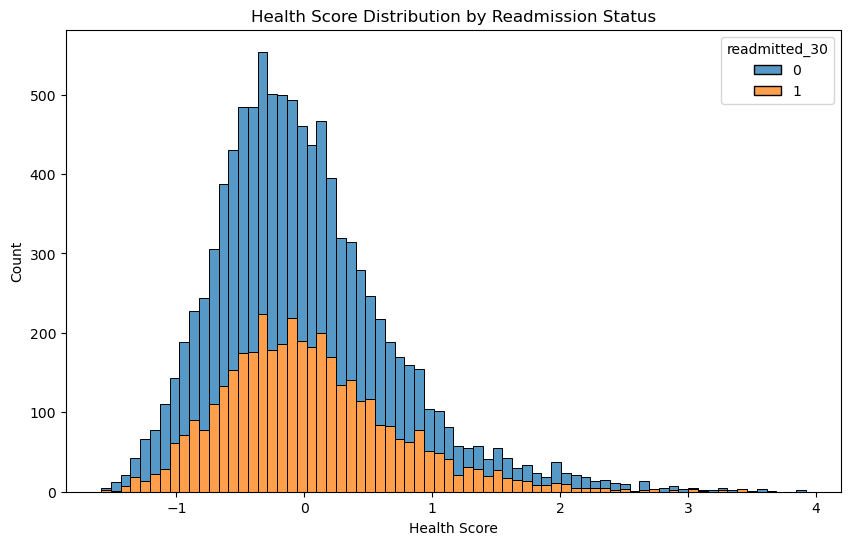

In [29]:
# Normalize components
numerical_cols = ['num_lab_procedures', 'num_procedures', 'num_medications']
scaler = StandardScaler()
normalized_vals = scaler.fit_transform(df[numerical_cols])

# Create health score
df['health_score'] = (normalized_vals[:, 0] * 0.3 + 
                     normalized_vals[:, 1] * 0.3 + 
                     normalized_vals[:, 2] * 0.4)

# Visualize health score distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='health_score', hue='readmitted_30', multiple="stack")
plt.title('Health Score Distribution by Readmission Status')
plt.xlabel('Health Score')
plt.ylabel('Count')
plt.show()

In [30]:
# One-hot encoding for nominal categorical variables
nominal_features = ['race', 'gender', 'medical_specialty']
for feature in nominal_features:
    dummies = pd.get_dummies(df[feature], prefix=feature)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(feature, axis=1)

# Label encoding for ordinal variables
ordinal_features = ['discharge_disposition_id', 'admission_source_id']
le = LabelEncoder()
for feature in ordinal_features:
    df[f'{feature}_encoded'] = le.fit_transform(df[feature].astype(str))

In [33]:
print("Available columns in original dataframe:")
print(df.columns.tolist())

Available columns in original dataframe:
['age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide.metformin', 'glipizide.metformin', 'glimepiride.pioglitazone', 'metformin.rosiglitazone', 'metformin.pioglitazone', 'change', 'diabetesMed', 'readmitted', 'diag_1_desc', 'diag_2_desc', 'diag_3_desc', 'age_numeric', 'readmitted_30', 'medication_changes', 'total_medications', 'insulin_status', 'primary_diagnosis_category', 'diag_cat_Cardiovascular', 'diag_cat_Diabet

In [35]:
# Update selected features to include all numerical features we want to scale
selected_features = [
    'age_numeric', 
    'time_in_hospital',
    'num_lab_procedures',
    'num_procedures', 
    'total_medications',
    'number_emergency',
    'number_inpatient',
    'health_score',
    'insulin_status', 
    'medication_changes', 
    'discharge_disposition_id_encoded',
    'admission_source_id_encoded'
] + [col for col in df.columns if col.startswith(('race_', 'gender_', 'diag_cat_'))]

# Create feature matrix and target vector
X = df[selected_features]

# Define numerical features to scale
numerical_features = [
    'age_numeric', 
    'time_in_hospital',
    'num_lab_procedures',
    'num_procedures', 
    'total_medications',
    'number_outpatient',
    'number_emergency',
    'number_inpatient',
    'health_score'
]

# Verify which features are available before scaling
available_numerical_features = [col for col in numerical_features if col in X.columns]
print("Available numerical features for scaling:", available_numerical_features)

# Scale only available numerical features
scaler = StandardScaler()
X[available_numerical_features] = scaler.fit_transform(X[available_numerical_features])

# Display final dataset shape
print("\nFinal feature matrix shape:", X.shape)
print("Number of features:", len(X.columns))
print("\nFeature names:")
print(X.columns.tolist())

# Display first few rows of scaled features
print("\nFirst few rows of scaled numerical features:")
print(X[available_numerical_features].head())

Available numerical features for scaling: ['age_numeric', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'total_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'health_score']

Final feature matrix shape: (10000, 26)
Number of features: 26

Feature names:
['age_numeric', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'total_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'health_score', 'insulin_status', 'medication_changes', 'discharge_disposition_id_encoded', 'admission_source_id_encoded', 'diag_cat_Cardiovascular', 'diag_cat_Diabetes', 'diag_cat_Other', 'diag_cat_Respiratory', 'diag_cat_Unknown', 'race_?', 'race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other', 'gender_Female', 'gender_Male']

First few rows of scaled numerical features:
   age_numeric  time_in_hospital  num_lab_procedures  num_procedures  \
0    -0.646774         -1.136774           -0.415302        1.5241

In [38]:
!pip3 install xgboost

##  Modeeling

In [39]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import seaborn as sns




In [40]:
def prepare_resource_features(df):
    """
    Prepare features for resource optimization model
    """
    resource_features = [
        'time_in_hospital',
        'num_lab_procedures',
        'num_procedures',
        'total_medications',
        'number_emergency',
        'number_inpatient',
        'age_numeric',
        'discharge_disposition_id_encoded',
        'admission_source_id_encoded'
    ] + [col for col in df.columns if col.startswith(('diag_cat_'))]
    
    return resource_features

In [ ]:
# For Resource Optimization
resource_features = prepare_resource_features(df)
X_resource = X[resource_features]

# Define resource targets
y_los = df['time_in_hospital']  # Length of stay
y_procedures = df['num_procedures']  # Number of procedures
y_medications = df['total_medications']  # Number of medications

# For Readmission Prevention
X_readmission = X  # Using all features for readmission prediction
y_readmission = df['readmitted_30']

# Split the data
X_resource_train, X_resource_test, y_los_train, y_los_test = train_test_split(
    X_resource, y_los, test_size=0.2, random_state=42
)

X_readm_train, X_readm_test, y_readm_train, y_readm_test = train_test_split(
    X_readmission, y_readmission, test_size=0.2, random_state=42
)